In [1]:
import os
import clip.clip as clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression, SGDClassifier
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model, preprocess = clip.load('/data/datasets/Epickitchens100_clips/ViT-B-16.pt', device)


cpu


In [2]:
import json
with open("/data/jong980812/project/Ego4d_dataset/annotations/fho_lta_taxonomy.json", encoding='utf-8') as f:
    taxonomy= json.load(f)
with open("/data/jong980812/project/Ego4d_dataset/annotations/my_annotations/lta_taxonomy_id_label.json", encoding='utf-8') as f:
    taxonomy_id= json.load(f)

In [4]:
nouns_list=taxonomy["nouns"]

In [5]:


print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [6]:
text_inputs = torch.cat([clip.tokenize(f"a first-person view photo of the person act with {c}") for c in nouns_list]).to(device)

In [3]:
from torchvision.io import read_image
from torchvision import transforms
from PIL import Image
class EGO4D_center(Dataset):
    def __init__(self, data_path,anno_path, transform=None, target_transform=None):
        super(EGO4D_center, self).__init__()
        self.data_path = data_path
        self.anno_path = anno_path
        self.transform = transform
        self.target_transform= target_transform
        import pandas as pd
        annotations = pd.read_csv(self.anno_path, header=None, delimiter=',')
        self.img_name = list(annotations.values[:, 0])
        self.labels= list(annotations.values[:,2])

        self.transform = transforms.Compose([
         transforms.Resize(size=256),
        transforms.CenterCrop(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
    ])

        self.target_transform = transforms.Compose([
            transforms.Resize((224, 224)),      # 개와 고양이 사진 파일의 크기가 다르므로, Resize로 맞춰줍니다.
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
        ])
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # file 경로
        img_path     = self.img_name[idx] + '.jpg'
        full_path    = os.path.join(self.data_path, img_path)
        # torchvision로 이미지 로드
        # image = read_image(full_path)
        image = Image.open(full_path)
        label = self.labels[idx]
        # transform 적용
        if self.transform:
            image = self.transform(image)
        # if self.target_transform:
        #     image = self.target_transform(image)
        # image, label return
        return image, label, full_path


In [8]:
train_datasets=EGO4D_center('/data/datasets/ego4d_center/lta/train/','/data/datasets/ego4d_clips/lta_train.csv',transform=True)


In [9]:
image, class_id,full_path = train_datasets[1000]
for i in taxonomy_id["nouns"]:
    if i["id"]==class_id:
        print(i["name"])
import torch

from PIL import Image
img = Image.fromarray((image).transpose(2,0).numpy().astype(np.uint8))

# Save the image
img.save('image.jpg',mode='L', vmin=0, vmax=1)
print(class_id)


dough
131


In [10]:
image_input = image.unsqueeze(0).to(device)

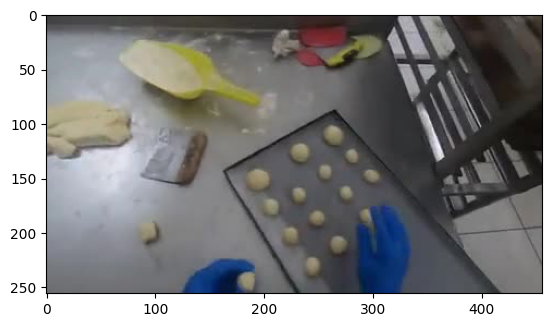

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(full_path)
plt.imshow(img)
plt.show()

In [26]:
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{nouns_list[index]:>16s}: {100 * value.item():.2f}%")
    print(int(index))



Top predictions:

           dough: 25.59%
131
     rolling_pin: 24.04%
335
     dough_mixer: 15.53%
132
          pastry: 14.36%
289
     baking_soda: 3.41%
11


In [29]:
image_features.shape
text_features.shape
similarity.shape

torch.Size([1, 478])

In [45]:
train_dataloader=DataLoader(train_datasets,10,num_workers=12)

In [71]:
count=0
with torch.no_grad():
    for a in train_dataloader:
        data=a[0]
        label=a[1]
        image_features = model.encode_image(data.to(device))
        text_features = model.encode_text(text_inputs)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        values, indices = similarity.topk(1)
        for i,k in enumerate(indices):
            pred=list(k)
            if pred[0]==label[i]:
                count+=1
        break;


print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{nouns_list[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

mower_(lawnmower,_mower): 74.02%
mower_(lawnmower,_mower): 78.42%
mower_(lawnmower,_mower): 73.14%
mower_(lawnmower,_mower): 89.99%
mower_(lawnmower,_mower): 82.37%
mower_(lawnmower,_mower): 27.15%
     screwdriver: 9.66%
shoe_(boot,_sandal,_shoe,_slipper): 4.02%
mower_(lawnmower,_mower): 65.33%
mower_(lawnmower,_mower): 85.01%


In [60]:
label

tensor([259, 259, 182, 190, 259, 259, 129, 105, 272, 259])

In [61]:
count

5

In [62]:
a[2]

('/data/datasets/ego4d_center/lta/train/1805_0.jpg',
 '/data/datasets/ego4d_center/lta/train/1805_1.jpg',
 '/data/datasets/ego4d_center/lta/train/1805_2.jpg',
 '/data/datasets/ego4d_center/lta/train/1805_3.jpg',
 '/data/datasets/ego4d_center/lta/train/1805_4.jpg',
 '/data/datasets/ego4d_center/lta/train/1805_5.jpg',
 '/data/datasets/ego4d_center/lta/train/1805_6.jpg',
 '/data/datasets/ego4d_center/lta/train/1805_7.jpg',
 '/data/datasets/ego4d_center/lta/train/1805_8.jpg',
 '/data/datasets/ego4d_center/lta/train/1805_9.jpg')

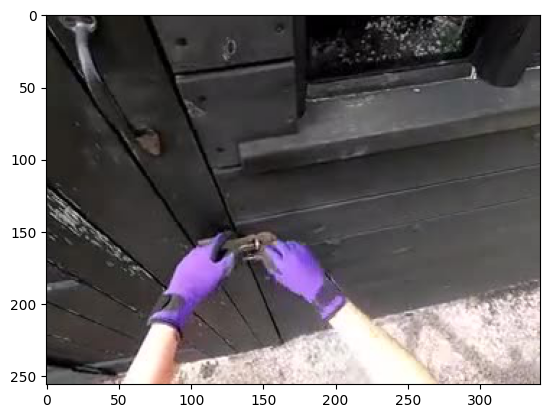

In [72]:
img = mpimg.imread('/data/datasets/ego4d_center/lta/train/1805_6.jpg')
plt.imshow(img)
plt.show()

In [7]:

import pandas as pd
annotations = pd.read_csv('/data/jong980812/project/CLIP/EPIC_100_noun_classes.csv', header=None, delimiter=',')
epic_noun_list = list(annotations.values[:, 1])

In [8]:
epic_noun_list

['key',
 'tap',
 'spoon',
 'plate',
 'cupboard',
 'knife',
 'pan',
 'lid',
 'bowl',
 'drawer',
 'sponge',
 'glass',
 'hand',
 'fridge',
 'cup',
 'fork',
 'bottle',
 'onion',
 'cloth',
 'board:chopping',
 'bag',
 'spatula',
 'container',
 'liquid:washing',
 'box',
 'hob',
 'dough',
 'package',
 'water',
 'meat',
 'pot',
 'potato',
 'oil',
 'cheese',
 'bread',
 'food',
 'tray',
 'bin',
 'pepper',
 'salt',
 'colander',
 'jar',
 'carrot',
 'top',
 'tomato',
 'kettle',
 'pasta',
 'oven',
 'sauce',
 'skin',
 'paper',
 'maker:coffee',
 'garlic',
 'towel',
 'egg',
 'rubbish',
 'rice',
 'mushroom',
 'chicken',
 'cutlery',
 'coffee',
 'glove',
 'can',
 'leaf',
 'sink',
 'milk',
 'heat',
 'jug',
 'aubergine',
 'salad',
 'chilli',
 'dishwasher',
 'mixture',
 'cucumber',
 'clothes',
 'peach',
 'flour',
 'courgette',
 'filter',
 'butter',
 'scissors',
 'chopstick',
 'tofu',
 'blender',
 'olive',
 'mat',
 'spice',
 'sausage',
 'peeler:potato',
 'napkin',
 'cover',
 'microwave',
 'pizza',
 'button',
 